1. Explain what your use is and why you chose it. (Background + problem statement)
2. What is the business metric? (recall, precicsion, accuracy, etc)
3. Import libraries
4. Get the data, split into training and testing data (show how target variable compares between the two)
5. Data exploration
    - Missing values
6. Transformations
    - Scaling
    - Normalization
    - Encoding
7. Models
    - Baseline Logistic regression
    - random forest
    - GBM
    - Decision Tree
    
    Accuraccy, AUC, Precision, Recall, F1
    
    ROC
8. Pick best model and explain why it is the best
9. Rerun best model on entire data set.

This dataset contains information about borrowers and will be used to predict whether or not someone will fully pay back a loan. A value of 1 in the target variable indicates that they did not fully pay off the loan. 

I chose this dataset because it had a significant number of data points (>5000) and it was a dataset I had not looked at before.

A false positive would be predicting that someone will not fully pay back a loan when in realty they would pay it back. The cost of a false positive is then the cost of not giving someone a loan: the lose of the profit you would get from that loan.

A false negative is the opposite situation, predicting that someone will fully pay back a loan when in reality they would not. The cost of a false negative is then the lose of the profit you would get from that loan along with some portion of the loan itself.

False negatives are more costly than false positives but both have a cost associated with them. The metric of interest is then a version of the F-score that weights false negatives more than false positives (F-2)


In [166]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.metrics import f1_score, fbeta_score, make_scorer
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import RocCurveDisplay
from sklearn.calibration import calibration_curve
from sklearn.model_selection import ShuffleSplit,train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, StandardScaler, MinMaxScaler, power_transform, PowerTransformer 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

## Pre data exploration

### Load dataset 

In [2]:
## https://www.kaggle.com/datasets/itssuru/loan-data
df = pd.read_csv('loan_data.csv')
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [3]:
#Rename target variable
df.rename(columns = {'not.fully.paid':'target'}, inplace = True)

### Check for missing data

In [4]:
#Check percentage of missing values in each column
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})

print(missing_value_df)

                   percent_missing
credit.policy                  0.0
purpose                        0.0
int.rate                       0.0
installment                    0.0
log.annual.inc                 0.0
dti                            0.0
fico                           0.0
days.with.cr.line              0.0
revol.bal                      0.0
revol.util                     0.0
inq.last.6mths                 0.0
delinq.2yrs                    0.0
pub.rec                        0.0
target                         0.0


In [5]:
df.shape

(9578, 14)

There are no missing values in this dataset so there is no need to impute anything.

### Add new features

In [6]:
# Add new features
df['revol.bal.zero'] = list(map(lambda x: 1 if x==0 else 0, df['revol.bal']))
df['revol.util.zero'] = list(map(lambda x: 1 if x==0 else 0, df['revol.util']))

During the data exploration process these two new features were considered and this is the easiest place to add them.

### Split off final testing data
Split off 20% of data as test data. This percentage is mostly arbitrary, I wanted to keep at least 5000 data points in the training and there's going to be another percentage split off for validation during the training process, so splitting off 20% twices leaves 9578*.8*.8 = 6130 data points for training.

In [7]:
#Separate target from other columns
X = df.drop(['target'], axis = 1)
y = df['target']

 ### Get train & test data
X_train, X_final_test, y_train, y_final_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

In [8]:
# merge X-train and y_train back into a single dataframe
df = pd.concat([X_train, y_train], axis=1)

## Data Exploration

In [9]:
#Check the balance of the data with respect to the target variable
df['target'].value_counts()/len(df)*100

0    83.998956
1    16.001044
Name: target, dtype: float64

This data set is unbalanced. It has 5 times as many data points with target = 0 compared to target = 1. Model trained on this data will tend to better at correcting identifying the overrepresented class than the underrepresented class. Logistics Regression has an option to counteract this. Tree based models might be able to handle this without doing anything special, but the unbalanced nature of the data set is something to keep in mind when training and evaulating models.

In [10]:
#Show data type and number of non-null values of each column 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7662 entries, 3847 to 5282
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      7662 non-null   int64  
 1   purpose            7662 non-null   object 
 2   int.rate           7662 non-null   float64
 3   installment        7662 non-null   float64
 4   log.annual.inc     7662 non-null   float64
 5   dti                7662 non-null   float64
 6   fico               7662 non-null   int64  
 7   days.with.cr.line  7662 non-null   float64
 8   revol.bal          7662 non-null   int64  
 9   revol.util         7662 non-null   float64
 10  inq.last.6mths     7662 non-null   int64  
 11  delinq.2yrs        7662 non-null   int64  
 12  pub.rec            7662 non-null   int64  
 13  revol.bal.zero     7662 non-null   int64  
 14  revol.util.zero    7662 non-null   int64  
 15  target             7662 non-null   int64  
dtypes: float64(6), int64(

The categorical features for this data set are credit.policy, purpose, and not.fully.paid; the last of which is the target variable. All of the rest are numerical

In [11]:
df.corr()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,revol.bal.zero,revol.util.zero,target
credit.policy,1.000000,-0.297422,0.058252,0.030376,-0.090400,0.345343,0.101304,-0.180165,-0.092133,-0.538911,-0.069880,-0.063913,-0.057394,-0.024605,-0.156793
int.rate,-0.297422,1.000000,0.278654,0.059140,0.220777,-0.713877,-0.126712,0.085832,0.458390,0.208554,0.159138,0.093899,-0.028008,-0.028694,0.163138
installment,0.058252,0.278654,1.000000,0.447444,0.051030,0.085743,0.181382,0.230928,0.087377,-0.009066,-0.007004,-0.031168,-0.073582,-0.033781,0.050670
log.annual.inc,0.030376,0.059140,0.447444,1.000000,-0.054313,0.116542,0.333853,0.375776,0.061119,0.032993,0.028250,0.023329,-0.106792,-0.060365,-0.037256
dti,-0.090400,0.220777,0.051030,-0.054313,1.000000,-0.238705,0.060288,0.189678,0.337239,0.034142,-0.019232,0.006709,-0.101717,-0.104354,0.033989
fico,0.345343,-0.713877,0.085743,0.116542,-0.238705,1.000000,0.271950,-0.008651,-0.536222,-0.187213,-0.215759,-0.148087,0.044000,0.076044,-0.148165
days.with.cr.line,0.101304,-0.126712,0.181382,0.333853,0.060288,0.271950,1.000000,0.237025,-0.029848,-0.045757,0.078356,0.065612,-0.059229,-0.038717,-0.030078
revol.bal,-0.180165,0.085832,0.230928,0.375776,0.189678,-0.008651,0.237025,1.000000,0.204295,0.015916,-0.032391,-0.025510,-0.095999,-0.053839,0.054865
revol.util,-0.092133,0.458390,0.087377,0.061119,0.337239,-0.536222,-0.029848,0.204295,1.000000,-0.016625,-0.040383,0.067825,-0.255328,-0.288738,0.077964
inq.last.6mths,-0.538911,0.208554,-0.009066,0.032993,0.034142,-0.187213,-0.045757,0.015916,-0.016625,1.000000,0.015914,0.080382,0.029760,0.017799,0.149851


## Plots
For categorical features, plots showing the probably that the target variable equals 1 for each possible value of that feature will be shown.

For numericals features, histograms of the feature along with box plots of the feature separated by value of the target variable will be shown. If the feature does not follow a normal distribution, a power transform will be used to attempt to make it normal.

This information will be used to decided which features will be good predictors and if any transformation are necessary.

<AxesSubplot:xlabel='credit.policy'>

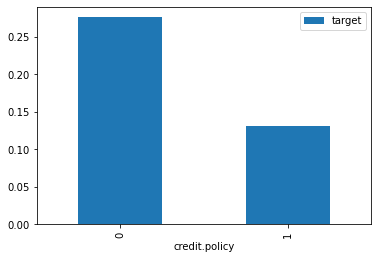

In [12]:
#Bar plot of percentage of data that has 'target' = 1 separated by value of 'credit.policy'
credit_policy_percents = pd.pivot_table(df, index = ['credit.policy'], values = 'target' , aggfunc =
{'target': np.mean})

credit_policy_percents.plot(kind = 'bar')

The target attribute is more likely to equal one when credit.policy is zero than when it is one. Since these two probablities are different credit.policy is a good predictor.

<AxesSubplot:xlabel='purpose'>

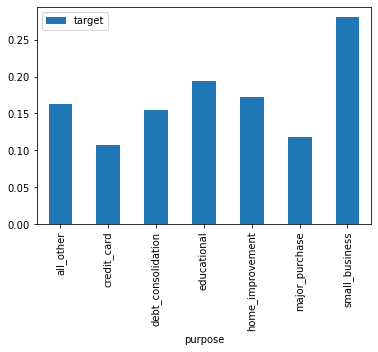

In [13]:
#Bar plot of percentage of data that has 'target' = 1 separated by value of 'purpose'
purpose_percents = pd.pivot_table(df, index = ['purpose'], values = 'target' , aggfunc =
{'target': np.mean})

purpose_percents.plot(kind = 'bar')

The probability of the target attribute equaling one is dependant on the value of purpose, therefore, purpose is a good predictor.

<AxesSubplot:xlabel='int.rate', ylabel='Count'>

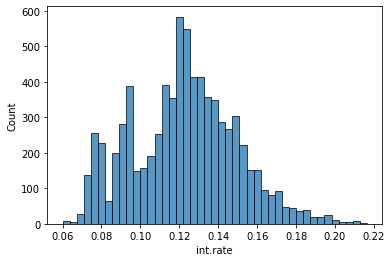

In [14]:
# Histgram of int.rate
sns.histplot(df['int.rate'])

This looks pretty normal, I'll do a normality test on this attribute and transformed versions of it to see if any are normal.

In [15]:
variable = 'int.rate'
k2, p = stats.normaltest(df[variable])
print(p)
k2, p = stats.normaltest(power_transform(df[[variable]], method='box-cox'))
print(p)
k2, p = stats.normaltest(power_transform(df[[variable]], method='yeo-johnson'))
print(p)

9.071671637320342e-12
[1.6741395e-13]
[3.77860697e-14]


p < .05 for all three so the null hypothis should be rejected in all three cases. The null hypothesis is this situtation is that the data comes from a normal distribution so rejecting it means that none of these are normally distributed.

There might be a different transform that makes this attribute normal, but I'll leave this untransformed.

<AxesSubplot:xlabel='target', ylabel='int.rate'>

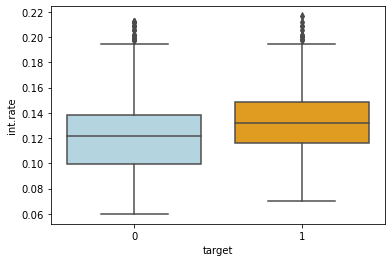

In [16]:
# Box plots of int.rate separated by value of target
c_palette = {0:'lightblue', 1:'orange'}
sns.boxplot(x='target', y='int.rate', data=df, orient='v', palette=c_palette)

The distribution of int.rate is slightly different depending on the value of the target variable. The distribution shifts up slightly when the target equals one, so int.rate is a good predictor.

<AxesSubplot:xlabel='installment', ylabel='Count'>

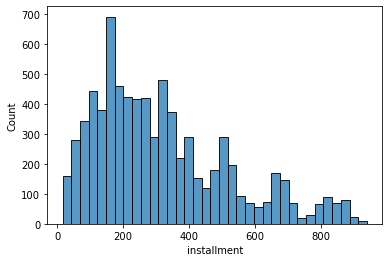

In [17]:
# Histgram of installment
sns.histplot(df['installment'])

This is skewed to the right. I'll do a normality test on this attribute and transformed versions of it to see if any are normal.

In [18]:
variable = 'installment'
k2, p = stats.normaltest(df[variable])
print(p)
k2, p = stats.normaltest(power_transform(df[[variable]], method='box-cox'))
print(p)
k2, p = stats.normaltest(power_transform(df[[variable]], method='yeo-johnson'))
print(p)

4.0866731344576077e-178
[1.35221881e-37]
[2.53802815e-38]


Again p < .05 for all three so the null hypothis should be rejected in all three cases, so none of these are normally distributed.

<AxesSubplot:ylabel='Count'>

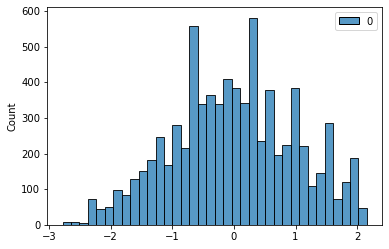

In [19]:
# Histgram of power transformed installment
sns.histplot(power_transform(df[['installment']], method='box-cox'))

The transformed data is at least less skewed than the untransformed version, I'll compare using each version when training the logistics regression later.

<AxesSubplot:xlabel='target', ylabel='installment'>

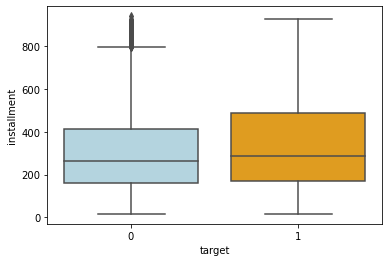

In [20]:
# Box plots of installment separated by value of target
c_palette = {0:'lightblue', 1:'orange'}
sns.boxplot(x='target', y='installment', data=df, orient='v', palette=c_palette)

The distribution of installment is slightly different depending on the value of the target variable. The distribution shifts up very slightly when the target equals one, so installment is probably a weak predictor.

<AxesSubplot:xlabel='log.annual.inc', ylabel='Count'>

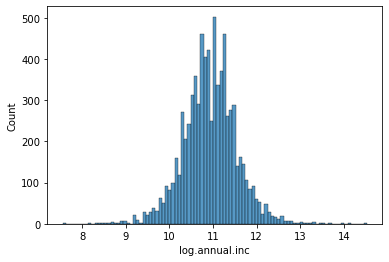

In [21]:
# Histgram of installment
sns.histplot(df['log.annual.inc'])

This looks pretty normal, I'll do a normality test on this attribute and transformed versions of it to see if any are normal.

In [22]:
variable = 'log.annual.inc'
k2, p = stats.normaltest(df[variable])
print(p)
k2, p = stats.normaltest(power_transform(df[[variable]], method='box-cox'))
print(p)
k2, p = stats.normaltest(power_transform(df[[variable]], method='yeo-johnson'))
print(p)

1.3942229286007077e-60
[6.17329249e-61]
[6.67722443e-61]


Again p < .05 for all three so the null hypothis should be rejected in all three cases, so none of these are normally distributed. Since this has already been log transformed there doesn't seem to be much point in transforming it again.

<AxesSubplot:xlabel='target', ylabel='log.annual.inc'>

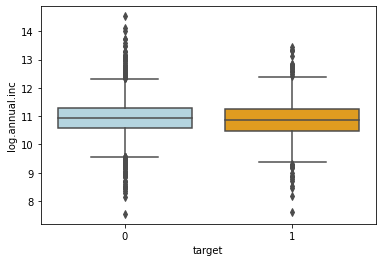

In [23]:
# Box plots of log.annual.inc separated by value of target
c_palette = {0:'lightblue', 1:'orange'}
sns.boxplot(x='target', y='log.annual.inc', data=df, orient='v', palette=c_palette)


The distribution of log.annual.inc is very similar for the two values of the target variable. The distribution seems to have fewer outliers when the target variable equals one, but this might just because the dataset is unbalanced and has fewer total points with the target equal to one. Comparing histograms should make it easier to see any differences.

In [24]:
df_0 = df[df.target==0]
df_1 = df[df.target==1]

<AxesSubplot:xlabel='log.annual.inc', ylabel='Count'>

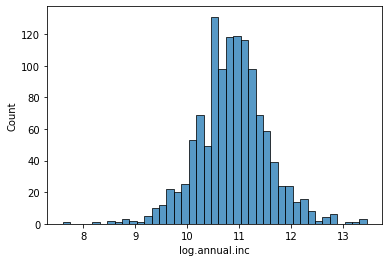

In [25]:
# Histgram of log.annual.inc when target = 1
sns.histplot(df_1['log.annual.inc'])

<AxesSubplot:xlabel='log.annual.inc', ylabel='Count'>

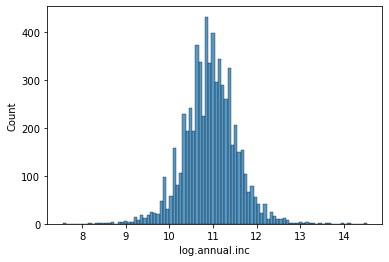

In [26]:
# Histgram of log.annual.inc when target = 0
sns.histplot(df_0['log.annual.inc'])

These two histograms look pretty similar. There are more outliers when the target equals zero, but that's only because there's more data points with the target equal to zero; log.annual.inc is not a good predictor.

<AxesSubplot:xlabel='dti', ylabel='Count'>

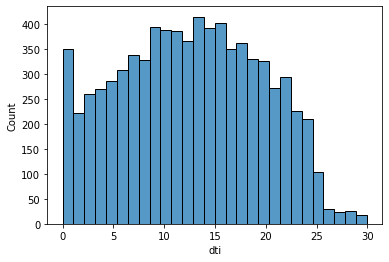

In [27]:
# Histgram of dti
sns.histplot(df['dti'])

This is definitely not normal. I'll do a normality test on the power transform to see if that is normal.

In [28]:
variable = 'dti'
k2, p = stats.normaltest(df[variable])
print(p)
k2, p = stats.normaltest(power_transform(df[[variable]], method='yeo-johnson'))
print(p)

1.730878416840298e-237
[5.36972681e-178]


p < .05 for both so neither are normally distributed

<AxesSubplot:ylabel='Count'>

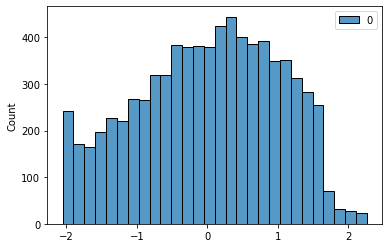

In [29]:
# Histgram of power transformed dti
sns.histplot(power_transform(df[['dti']], method='yeo-johnson'))

The transformed version looks very similar to the untransformed version so there doesn't seem to be any reason to use this transform.

<AxesSubplot:xlabel='target', ylabel='dti'>

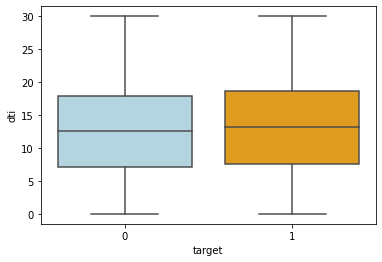

In [30]:
# Box plots of dti separated by value of target
c_palette = {0:'lightblue', 1:'orange'}
sns.boxplot(x='target', y='dti', data=df, orient='v', palette=c_palette)

The distribution of dti is almost identical for the two values of the target variable; dti is not a good predictor.

<AxesSubplot:xlabel='fico', ylabel='Count'>

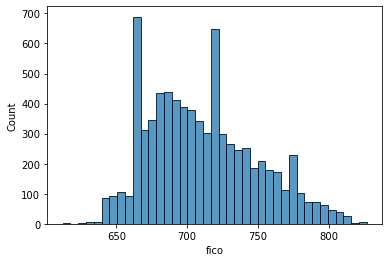

In [31]:
# Histgram of dti
sns.histplot(df['fico'])

This is skewed to the right.  I'll do a normality test on this attribute and transformed versions of it to see if any are normal.

In [32]:
variable = 'fico'
k2, p = stats.normaltest(df[variable])
print(p)
k2, p = stats.normaltest(power_transform(df[[variable]], method='box-cox'))
print(p)
k2, p = stats.normaltest(power_transform(df[[variable]], method='yeo-johnson'))
print(p)

1.763681782237526e-77
[1.75500901e-74]
[0.]


C:\Users\anton\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


p < .05 for all three so the null hypothis should be rejected in all three cases, so none of these are normally distributed.

<AxesSubplot:ylabel='Count'>

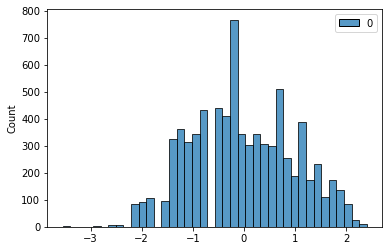

In [33]:
# Histgram of power transformed fico
sns.histplot(power_transform(df[['fico']], method='box-cox'))

This looks less skewed, so I'll compare using each version when training the logistics regression later.

<AxesSubplot:xlabel='target', ylabel='fico'>

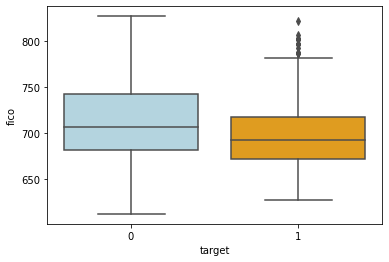

In [34]:
# Box plots of fico separated by value of target
c_palette = {0:'lightblue', 1:'orange'}
sns.boxplot(x='target', y='fico', data=df, orient='v', palette=c_palette)

The distribution of fico is slightly different depending on the value of the target variable. The distribution shifts down slightly and the variance descreases when the target equals one, so fico is probably a weak predictor.

<AxesSubplot:xlabel='days.with.cr.line', ylabel='Count'>

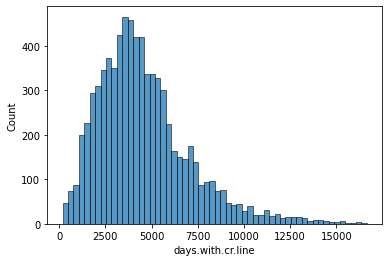

In [35]:
# Histgram of days.with.cr.line
sns.histplot(df['days.with.cr.line'])

This is skewed to the right. I'll do a normality test on this attribute and transformed versions of it to see if any are normal.

In [36]:
variable = 'days.with.cr.line'
k2, p = stats.normaltest(df[variable])
print(p)
k2, p = stats.normaltest(power_transform(df[[variable]], method='box-cox'))
print(p)
k2, p = stats.normaltest(power_transform(df[[variable]], method='yeo-johnson'))
print(p)

0.0
[0.00032252]
[0.0003311]


p < .05 for all three so the null hypothis should be rejected in all three cases, so none of these are normally distributed.

<AxesSubplot:ylabel='Count'>

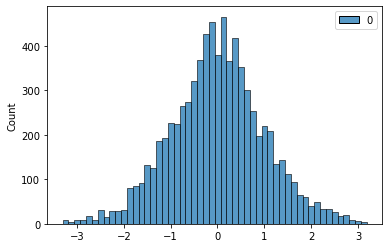

In [37]:
# Histgram of power transformed days.with.cr.line
sns.histplot(power_transform(df[['days.with.cr.line']], method='box-cox'))

The transformed data is at least less skewed than the untransformed version, I'll compare using each version when training the logistics regression later.

<AxesSubplot:xlabel='target', ylabel='days.with.cr.line'>

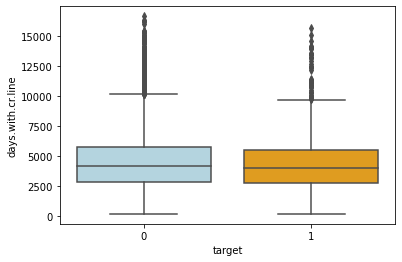

In [38]:
# Box plots of fico separated by value of target
c_palette = {0:'lightblue', 1:'orange'}
sns.boxplot(x='target', y='days.with.cr.line', data=df, orient='v', palette=c_palette)

The distribution of days.with.cr.line is very similar for the two values of the target variable. The distribution seems to have fewer outliers when the target variable equals one, but this is probably just because the dataset is unbalanced and has fewer total points with the target equal to one. Comparing histograms should make it easier to see any differences.

<AxesSubplot:xlabel='days.with.cr.line', ylabel='Count'>

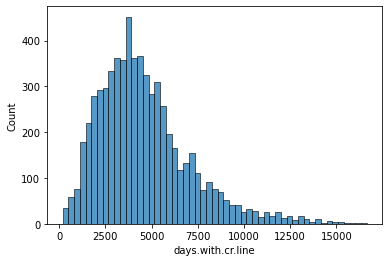

In [39]:
# Histgram of days.with.cr.line when target = 0
sns.histplot(df_0['days.with.cr.line'])

<AxesSubplot:xlabel='days.with.cr.line', ylabel='Count'>

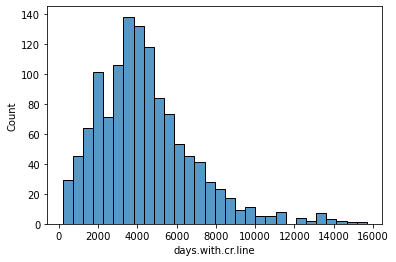

In [40]:
# Histgram of days.with.cr.line when target = 1
sns.histplot(df_1['days.with.cr.line'])

These two histograms look pretty similar. There are more outliers when the target equals zero, but that's only because there's more data points with the target equal to zero; days.with.cr.line is not a good predictor.

<AxesSubplot:xlabel='revol.bal', ylabel='Count'>

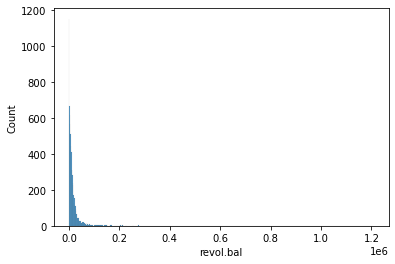

In [41]:
# Histgram of revol.bal
sns.histplot(df['revol.bal'])

This has some extreme outliers that are making it difficult to the shape of the graph.

<AxesSubplot:xlabel='revol.bal', ylabel='Count'>

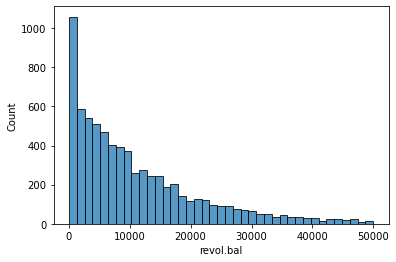

In [43]:
# Histgram of revol.bal cutting off some of the extreme values
sns.histplot(df['revol.bal'], binrange=(0,50000))

This is skewed right, let's look at using a power transform.

<AxesSubplot:ylabel='Count'>

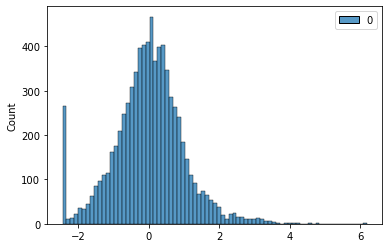

In [214]:
# Histgram of power transformed 'revol.bal'
sns.histplot(power_transform(df[['revol.bal']], method='yeo-johnson'))

This is looks more like a normal distribution, let's see if removing the zeroes and doing a power transform it results in a normal distribution.

In [45]:
variable = 'revol.bal.zero'
df_no_zeroes = df[df[variable] != 0]
k2, p = stats.normaltest(df_no_zeroes[variable])
print(p)
k2, p = stats.normaltest(power_transform(df_no_zeroes[[variable]], method='yeo-johnson'))
print(p)

5.5463352400717954e-192
[5.54633524e-192]


C:\Users\anton\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


p < .05 for both so the null hypothis should be rejected in both cases, so neither of these are normally distributed.
Since the original data is so skewed and has a large number of zeroes, I'll do a power transform on revol.bal add a column that's 1 exactly when revol.bal = 0.

<AxesSubplot:xlabel='target', ylabel='revol.bal'>

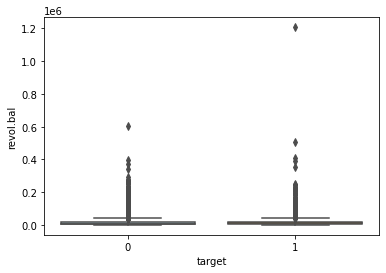

In [46]:
# Box plots of revol.bal separated by value of target
c_palette = {0:'lightblue', 1:'orange'}
sns.boxplot(x='target', y='revol.bal', data=df, orient='v', palette=c_palette)

The extreme outliers are making this difficult to see. If some of the largest values are removed it will be easier to see the boxplots

<AxesSubplot:xlabel='target', ylabel='revol.bal'>

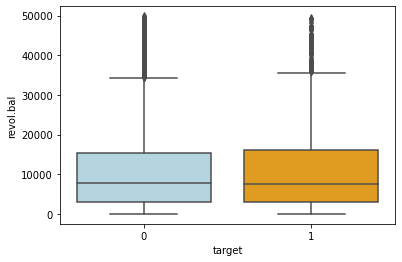

In [47]:
df_minus_outlier = df[df['revol.bal'] < 50000]
c_palette = {0:'lightblue', 1:'orange'}
sns.boxplot(x='target', y='revol.bal', data=df_minus_outlier, orient='v', palette=c_palette)

These are nearly identical, but the fact that some of the values have been removed changes some of the statistics.

In [48]:
df_0['revol.bal'].describe()

count      6436.000000
mean      15921.707893
std       27461.024378
min           0.000000
25%        3163.750000
50%        8505.500000
75%       17755.500000
max      602519.000000
Name: revol.bal, dtype: float64

In [49]:
df_1['revol.bal'].describe()

count    1.226000e+03
mean     2.081178e+04
std      5.193227e+04
min      0.000000e+00
25%      3.385500e+03
50%      8.815000e+03
75%      1.960825e+04
max      1.207359e+06
Name: revol.bal, dtype: float64

The the mean, std, and quartiles are all slightly higher when the target variable is 1. The distribution of revol.bal is pretty similar for both values of the targer variable, expect it has some more extreme values when the target variable is 1; revol.bal is probably a weak predictor.

<AxesSubplot:xlabel='revol.util', ylabel='Count'>

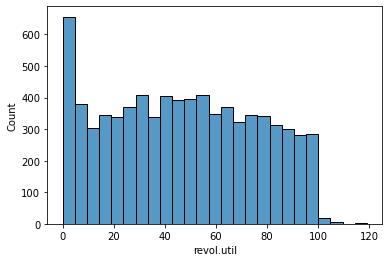

In [50]:
# Histgram of revol.util
sns.histplot(df['revol.util'])

This looks like a uniform distribution, except for the spike at 0 and a small number of the highest values.

In [51]:
variable = 'revol.util'
k2, p = stats.normaltest(df[variable])
print(p)
k2, p = stats.normaltest(power_transform(df[[variable]], method='yeo-johnson'))
print(p)

0.0
[8.7271242e-286]


p < .05 so neither the orginal data or the transformed version are normal.

<AxesSubplot:xlabel='revol.util', ylabel='Count'>

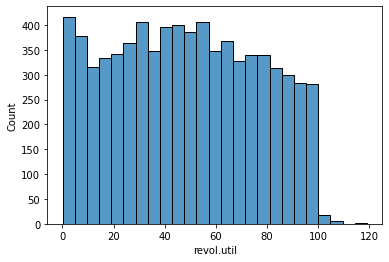

In [52]:
df_no_zeroes = df[df['revol.util'] != 0]
#Histgram of revol.util with zeroes removed
sns.histplot(df_no_zeroes['revol.util'])

Since this looks more like a uniform distribution onces the zeroes are removed I'm going to add an extra feature that's 1 exactly when revol.util = 0.

<AxesSubplot:xlabel='target', ylabel='revol.util'>

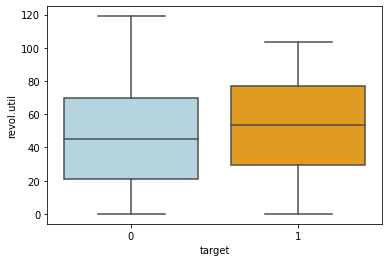

In [53]:
# Box plots of revol.util separated by value of target
c_palette = {0:'lightblue', 1:'orange'}
sns.boxplot(x='target', y='revol.util', data=df, orient='v', palette=c_palette)

The distribution of revol.util is slightly different depending on the value of the target variable. The median, and 1st and 3rd quartiles increase very slightly when the target equals one, so revol.util is probably a weak predictor.

<AxesSubplot:xlabel='inq.last.6mths', ylabel='Count'>

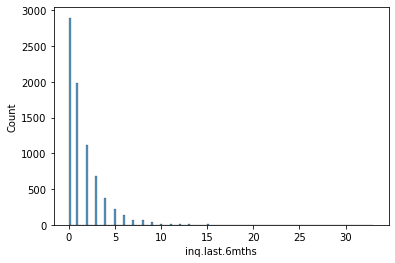

In [54]:
# Histgram of inq.last.6mths
sns.histplot(df['inq.last.6mths'])

In [55]:
variable = 'inq.last.6mths'
k2, p = stats.normaltest(df[variable])
print(p)
k2, p = stats.normaltest(power_transform(df[[variable]], method='yeo-johnson'))
print(p)

0.0
[0.]


p < .05 for both so the null hypothis should be rejected in both cases, so neither of these are normally distributed.

<AxesSubplot:ylabel='Count'>

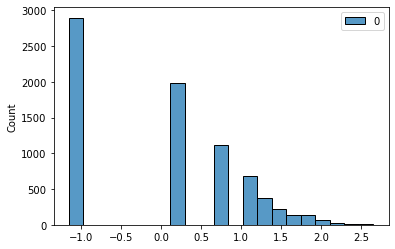

In [56]:
# Histgram of inq.last.6mths
sns.histplot(power_transform(df[['inq.last.6mths']], method='yeo-johnson'))

The transformed version isn't any more like a normal distribution than the untransformed version so I don't see much reason to transform this feature.

<AxesSubplot:xlabel='target', ylabel='inq.last.6mths'>

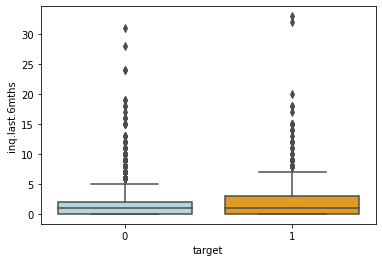

In [57]:
# Box plots of inq.last.6mths separated by value of target
c_palette = {0:'lightblue', 1:'orange'}
sns.boxplot(x='target', y='inq.last.6mths', data=df, orient='v', palette=c_palette)

Differences between these two plots are difficult to see clearly, except the 3rd quartile is slightly higher when the target variable is 1.

<AxesSubplot:xlabel='target', ylabel='inq.last.6mths'>

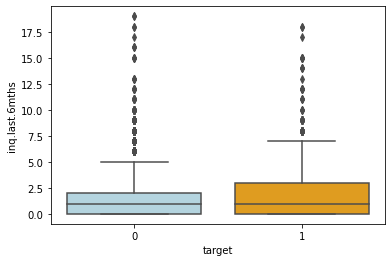

In [58]:
df_minus_outlier = df[df['inq.last.6mths'] < 20]
c_palette = {0:'lightblue', 1:'orange'}
sns.boxplot(x='target', y='inq.last.6mths', data=df_minus_outlier, orient='v', palette=c_palette)

These are very similar, but the 3rd quartile is slightly higher when the target variable is 1;  inq.last.6mths is not probably not a good predictor.

<AxesSubplot:xlabel='delinq.2yrs', ylabel='Count'>

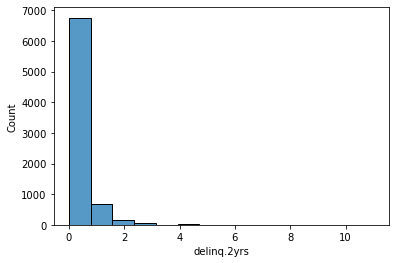

In [59]:
# Histgram of delinq.2yrs
sns.histplot(df['delinq.2yrs'])

In [60]:
print(pd.unique(df['delinq.2yrs']))
print(len(pd.unique(df['delinq.2yrs'])))

[ 0  1  2  5  3  6  4  7  8 11]
10


Since there's only 10 unique values for pub.rec there doesn't seem to be much point in transforming it, any transform is just going to be 10 different values. I could try treating it like a categorical feature and one-hot encode it, but if there's any data points in the testing data with delinq.2yrs equal to any of the missing values or greater than 11 they wouldn't get handled well.

<AxesSubplot:xlabel='delinq.2yrs'>

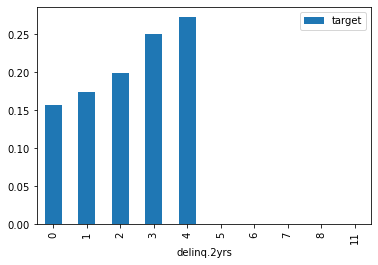

In [61]:
#Bar plot of percentage of data that has 'target' = 1 separated by value of 'delinq.2yrs'
delinq_2yrs_percents = pd.pivot_table(df, index = ['delinq.2yrs'], values = 'target' , aggfunc =
{'target': np.mean})

delinq_2yrs_percents.plot(kind = 'bar')

Since these bars are all different heights, the value of delinq.2yrs has a strong effect on the probability of the target variable being 1 so delinq.2yrs is good predictor. 

The probability of target equaling 1 drops 0 once delinq.2yrs is greater than 4 rather than continueing the upward trend before that. This is probably do to the small number of data points with delinq.2yrs greater than 4, all of them coicidentally have the target equal to 0.

<AxesSubplot:xlabel='pub.rec', ylabel='Count'>

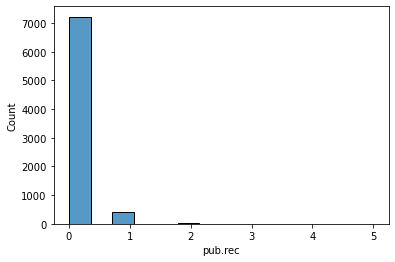

In [62]:
# Histgram of pub.rec
sns.histplot(df['pub.rec'])

In [63]:
pd.unique(df['pub.rec'])

array([0, 1, 2, 3, 4, 5], dtype=int64)

Since there's only 6 unique values for pub.rec there doesn't seem to be much point in transforming it, any transform is just going to be 6 different values. I could try treating it like a categorical feature and one-hot encode it, but if there's any data points in the testing data with pub.rec > 5 they wouldn't get handled well.

<AxesSubplot:xlabel='pub.rec'>

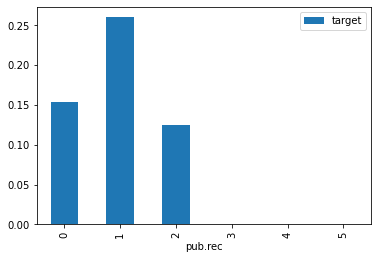

In [64]:
#Bar plot of percentage of data that has 'target' = 1 separated by value of 'pub.rec'
pub_rec_percents = pd.pivot_table(df, index = ['pub.rec'], values = 'target' , aggfunc =
{'target': np.mean})

pub_rec_percents.plot(kind = 'bar')

Since these bars are all different heights, the value of pub.rec has a strong effect on the probability of the target variable being 1 so pub.rec is good predictor. 

This feature could also be treated as a categorical feature with possible values of 0, 1, 2, and >2.

## Models

### Separate features by type

In [65]:
# Make list of categorical columns
categorical_features = pd.Index(['credit.policy', 'purpose','revol.bal.zero', 'revol.util.zero'])

# Get list of numerical columns by removing categorical features and the target variable
numerical_features = df.columns
numerical_features = numerical_features.drop(categorical_features)
numerical_features = numerical_features.drop(['target'])

# Make list of columns that a power transform might be used on
power_features = pd.Index(['installment', 'fico', 'revol.bal'])

# Make list of columns to possibly omit because they are bad predictors
omit_features = pd.Index(['log.annual.inc', 'dti', 'days.with.cr.line', 'inq.last.6mths'])

# Make list of new columns to possibly include
new_features = pd.Index(['revol.bal.zero', 'revol.util.zero'])


print(numerical_features)
print(categorical_features)

Index(['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico',
       'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths',
       'delinq.2yrs', 'pub.rec'],
      dtype='object')
Index(['credit.policy', 'purpose', 'revol.bal.zero', 'revol.util.zero'], dtype='object')


### Preprocessing pipeline

In [66]:
#Create pipeline for imputing missing data and scaling


# Pipeline for numerical columns
numeric_transformer = Pipeline(
steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

# Pipeline for categorical columns
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Pipeline for power transformer
power_transformer = PowerTransformer()

preprocessors = []

# Create preprocessor for each combination of
# whether or not to do a power transform
# whether or not to omit certain features
# whether or not to use 
for power in [True, False]:
    for omit in [True, False]:
        for new in [True, False]:
            features = []
            features.append(numerical_features)
            
            if power:
                features.append(power_features)
                features[0] = features[0].drop(power_features)
            else:
                features.append(pd.Index([]))
                
            features.append(categorical_features)
            if omit:
                features[0] = features[0].drop(omit_features)
            if not new:
                features[2] = features[2].drop(new_features)
        # Combine pipelins
            preprocessors.append( ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, features[0]),
                ("pow", power_transformer, features[1]),
                ("cat", categorical_transformer, features[2]),]))

The numerical features are put through a scaler that subtracts the mean then divides by the standard deviation, this helps with the convergence of the logistics regression.

The categorical features are one-hot encoded, this converts the categorical features to numerical data that the models can use.

Now there are 8 different pipelines for each combination of special treatments to apply to the data (power transform, omit certain features, add new features). I could go divide this even further into selecting which specific columns to power transform instead of just the three it looked like it might help and similarly with omitting features and adding new features, but that would be way too much for this project.

These different pipelines are only needed for the logistics regression, the other models chosen are all tree based and do not really need any feature engineering, if it is important the model will "figure it out" on its own.

In [67]:
#Separate target from other columns
X = df.drop(['target'], axis = 1)
y = df['target']

 ### Get train & test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

In [208]:
# Dataframe for final results
results_final = pd.DataFrame(columns = ['model','accuracy', 'precision', 'AUC', 'recall', 'F1', 'F2', 'confusion matrix'])
# Dataframe for results of model training
results = pd.DataFrame(columns = ['model','train accuracy', 'test accuracy', 'precision', 'recall', 'AUC', 'F1', 'F2', 'confusion matrix'])
# Dataframe for just logistics regression results
results_logi = pd.DataFrame(columns = ['model','train accuracy', 'test accuracy', 'precision', 'recall', 'AUC', 'F1', 'F2', 'confusion matrix'])

### Logistics Regression
Two different logistics regressions will be used, one with all the default options and one with class_weight='balanced' which will give a higher weight to the underrepresented class of the target variable, this often works better for unbalanced data sets and prevents the model from over predicting data points as the overrepresented class.

In [190]:
 for pre in preprocessors:
    # Add logistic regression to pipeline
    logi = Pipeline(
    steps=[("preprocessor", pre), ("classifier", LogisticRegression())]
    )

    # Fit model and training data
    logi.fit(X_train, y_train)

    y_pred = logi.predict(X_test)

    scores = {};
    scores['model'] = ['Logistic Regression']
    scores['train accuracy'] = [logi.score(X_train, y_train)]
    scores['test accuracy'] = [logi.score(X_test, y_test)]
    scores['precision'] = [precision_score(y_test, y_pred)]
    scores['recall'] =  [recall_score(y_test, y_pred)]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    scores['AUC'] = auc(fpr, tpr)
    
    
    scores['F1'] = [f1_score(y_test, y_pred)]
    scores['F2'] = [fbeta_score(y_test, y_pred, beta=2)]
    scores['confusion matrix'] = [confusion_matrix(y_test, y_pred)]
    scores = pd.DataFrame.from_dict(scores)
    results_logi = pd.concat([results_logi, scores],ignore_index=True)

In [191]:
for pre in preprocessors:
    # Add logistic regression to pipeline
    logi = Pipeline(
    steps=[("preprocessor", pre), ("classifier", LogisticRegression(class_weight='balanced'))]
    )

    # Fit model and training data
    logi.fit(X_train, y_train)

    y_pred = logi.predict(X_test)

    scores = {};
    scores['model'] = ['Logistic Regression - Balanced']
    scores['train accuracy'] = [logi.score(X_train, y_train)]
    scores['test accuracy'] = [logi.score(X_test, y_test)]
    scores['precision'] = [precision_score(y_test, y_pred)]
    scores['recall'] =  [recall_score(y_test, y_pred)]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    scores['AUC'] = auc(fpr, tpr)

    
    scores['F1'] = [f1_score(y_test, y_pred)]
    scores['F2'] = [fbeta_score(y_test, y_pred, beta=2)]
    scores['confusion matrix'] = [confusion_matrix(y_test, y_pred)]
    scores = pd.DataFrame.from_dict(scores)
    results_logi = pd.concat([results_logi, scores],ignore_index=True)

In [192]:
results_logi

,model,train accuracy,test accuracy,precision,recall,AUC,F1,F2,confusion matrix
0,Logistic Regression,0.840920,0.840183,0.500000,0.012245,0.504958,0.023904,0.015213,"[[1285, 3], [242, 3]]"
1,Logistic Regression,0.841083,0.840183,0.500000,0.012245,0.504958,0.023904,0.015213,"[[1285, 3], [242, 3]]"
2,Logistic Regression,0.841083,0.840835,0.533333,0.032653,0.513609,0.061538,0.040201,"[[1281, 7], [237, 8]]"
3,Logistic Regression,0.841736,0.839530,0.466667,0.028571,0.511180,0.053846,0.035176,"[[1280, 8], [238, 7]]"
4,Logistic Regression,0.841736,0.839530,0.428571,0.012245,0.504570,0.023810,0.015198,"[[1284, 4], [242, 3]]"
5,Logistic Regression,0.842225,0.839530,0.428571,0.012245,0.504570,0.023810,0.015198,"[[1284, 4], [242, 3]]"
6,Logistic Regression,0.841736,0.841487,0.571429,0.032653,0.513997,0.061776,0.040241,"[[1282, 6], [237, 8]]"
7,Logistic Regression,0.841573,0.840835,0.533333,0.032653,0.513609,0.061538,0.040201,"[[1281, 7], [237, 8]]"
8,Logistic Regression - Balanced,0.645456,0.641226,0.230088,0.530612,0.596440,0.320988,0.420712,"[[853, 435], [115, 130]]"
9,Logistic Regression - Balanced,0.645782,0.649706,0.237410,0.538776,0.604791,0.329588,0.429687,"[[864, 424], [113, 132]]"


Using the balanced option in the logistics regression greatly improves the recall and the F2 ( our business metric)

The best model is the one where no special treatments where done to the data. (Didn't do any power transforms, left it all the features, and didn't add new features)

### Random Forest

In [70]:
# Make scorer for grid search
ftwo_scorer = make_scorer(fbeta_score, beta=2)

# Set categorical_features back the original features by removing the added features
categorical_features = categorical_features.drop(new_features)
# Combine pipelines
preprocessor = ColumnTransformer(
    transformers=[
                ("num", numeric_transformer, numerical_features),
                ("cat", categorical_transformer, categorical_features),])

In [161]:
# Add forest to pipeline
forest = Pipeline(
steps=[("preprocessor", preprocessor), 
       ("classifier", RandomForestClassifier(random_state=0))])


# Parameters for grid search
parameters = {'classifier__n_estimators':(3,4,5,6,7),
              'classifier__max_depth':(3,4,5,10), 
              'classifier__criterion':('entropy', 'gini'), 
              'classifier__min_samples_leaf':(1,5,10),
              'classifier__max_features' :(.1,.2),  
              'classifier__ccp_alpha': (0,.01,.015,.02),
              'classifier__class_weight': (None, 'balanced')}
best_forest = GridSearchCV(forest, parameters, scoring=ftwo_scorer)
best_forest.fit(X,y)
print(best_forest.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico',
       'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths',
       'delinq.2yrs', 'pub.rec'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['credit.policy', 'purpose'], dtype='object'))])),
                ('classifier',
                 RandomForestCla

### Gradient Boosting

In [196]:
# Add forest to pipeline
GBM = Pipeline(
steps=[("preprocessor", preprocessor), 
       ("classifier", GradientBoostingClassifier(random_state=0))])


# Parameters for grid search
parameters = {'classifier__n_estimators':(3,4,5,10),
              'classifier__max_depth':(20,25,30), 
              'classifier__learning_rate':(.1, .5, .7,.9, 1),  
              'classifier__ccp_alpha': (0,.005,.01),
}
best_GBM = GridSearchCV(GBM, parameters, scoring=ftwo_scorer)
best_GBM.fit(X,y)
print(best_GBM.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico',
       'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths',
       'delinq.2yrs', 'pub.rec'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['credit.policy', 'purpose'], dtype='object'))])),
                ('classifier',
                 GradientBoostin

### Decision Tree

In [136]:
# Add Tree to pipeline
tree = Pipeline(
steps=[("preprocessor", preprocessor), ("classifier", DecisionTreeClassifier(random_state=0))]
)

# Parameters for gridsearch
parameters = {'classifier__max_depth':(2,5,10,20,25), 
              'classifier__criterion':('entropy', 'gini'), 
              'classifier__min_samples_leaf':(1,2,5,10,20,25),
              'classifier__max_features' :(.1,.3,.5,.7,.9),  
              'classifier__ccp_alpha': (0,),
              'classifier__class_weight': (None, 'balanced')}
best_tree = GridSearchCV(tree, parameters, scoring=ftwo_scorer)
best_tree.fit(X,y)
print(best_tree.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico',
       'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths',
       'delinq.2yrs', 'pub.rec'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['credit.policy', 'purpose'], dtype='object'))])),
                ('classifier',
                 DecisionTreeCla

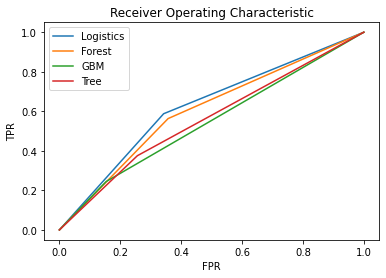

In [209]:
models = [('Logistics', LogisticRegression(class_weight='balanced')), 
          ('Forest',   RandomForestClassifier(ccp_alpha=0.015, class_weight='balanced',
                                        criterion='entropy', max_depth=5,
                                        max_features=0.1, n_estimators=4,
                                        random_state=0)),
          ('GBM',
                 GradientBoostingClassifier(ccp_alpha=0, learning_rate=1,
                                            max_depth=25, n_estimators=4,
                                            random_state=0)),
          ('Tree',      DecisionTreeClassifier(ccp_alpha=0, class_weight='balanced',
                                        max_depth=5, max_features=0.1,
                                        min_samples_leaf=5, random_state=0)) ]

for model in models:
    # Add logistic regression to pipeline
    pipe = Pipeline(
    steps=[("preprocessor", preprocessor), model]
    )

    # Fit model and training data
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    scores = {};
    scores['model'] = [model[0]]
    scores['train accuracy'] = [pipe.score(X_train, y_train)]
    scores['test accuracy'] = [pipe.score(X_test, y_test)]
    scores['precision'] = [precision_score(y_test, y_pred)]
    scores['recall'] =  [recall_score(y_test, y_pred)]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    scores['AUC'] = auc(fpr, tpr)

    scores['F1'] = [f1_score(y_test, y_pred)]
    scores['F2'] = [fbeta_score(y_test, y_pred, beta=2)]
    scores['confusion matrix'] = [confusion_matrix(y_test, y_pred)]
    scores = pd.DataFrame.from_dict(scores)
    results = pd.concat([results, scores],ignore_index=True)
    

    plt.plot(fpr, tpr, label= model[0])

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

In [210]:
results

,model,train accuracy,test accuracy,precision,recall,AUC,F1,F2,confusion matrix
0,Logistics,0.645782,0.646445,0.246154,0.587755,0.622682,0.346988,0.460064,"[[847, 441], [101, 144]]"
1,Forest,0.631588,0.630137,0.230769,0.563265,0.603061,0.327402,0.437262,"[[828, 460], [107, 138]]"
2,GBM,1.000000,0.750163,0.232558,0.244898,0.545586,0.238569,0.242326,"[[1090, 198], [185, 60]]"
3,Tree,0.693425,0.684932,0.218009,0.375510,0.559650,0.275862,0.328103,"[[958, 330], [153, 92]]"


The logistics regression is the best model. It scores the highest in the metric of interest, F2-score, and has the highest precision, recalls, and AUC. Its ROC curve is also higher (closer to the top left corner) than all the others.

It's still not great, it's only identifying about 60% of the people that will not fully pay loans (recall = .58) and 75% of those it identifies as not fully paying back their loan will actually fully pay it.

Random Forest does the second best and maybe if the hyperparameters were adjusting better it could outperform the logistics regression.

GBM is overfitting to the data, it does really well on the training data but underperforms on the test data. This could probably be fixed by further hyperparameter fitting or special treatment for the unbalanced dataset.

## Final Results

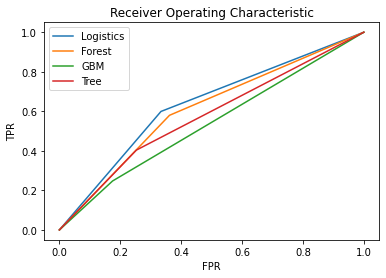

In [211]:
for model in models:
    # Add logistic regression to pipeline
    pipe = Pipeline(
    steps=[("preprocessor", preprocessor), model]
    )


    y_pred = pipe.predict(X_final_test)

    scores = {};
    scores['model'] = [model[0]]
    scores['accuracy'] = [pipe.score(X_final_test, y_final_test)]
    scores['precision'] = [precision_score(y_final_test, y_pred)]
    scores['recall'] =  [recall_score(y_final_test, y_pred)]
    
    fpr, tpr, thresholds = roc_curve(y_final_test, y_pred, pos_label=1)
    scores['AUC'] = auc(fpr, tpr)

    scores['F1'] = [f1_score(y_final_test, y_pred)]
    scores['F2'] = [fbeta_score(y_final_test, y_pred, beta=2)]
    scores['confusion matrix'] = [confusion_matrix(y_final_test, y_pred)]
    scores = pd.DataFrame.from_dict(scores)
    results_final = pd.concat([results_final, scores],ignore_index=True)
    

    plt.plot(fpr, tpr, label= model[0])

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

In [212]:
results_final

,model,accuracy,precision,AUC,recall,F1,F2,confusion matrix
0,Logistics,0.655532,0.255201,0.632800,0.599349,0.357977,0.472037,"[[1072, 537], [123, 184]]"
1,Forest,0.628914,0.234211,0.609045,0.579805,0.333646,0.447686,"[[1027, 582], [129, 178]]"
2,GBM,0.732777,0.212885,0.536457,0.247557,0.228916,0.239748,"[[1328, 281], [231, 76]]"
3,Tree,0.692067,0.233522,0.575478,0.403909,0.295943,0.352473,"[[1202, 407], [183, 124]]"


The logistics regression still performs best followed by the random forest.